In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using SciPy
using Statistics
using CairoMakie

In [2]:
function sigma(x)
    return @fastmath 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

function error_synch(x, y)
            nt = 10000
            error = ( 1 / ( 2 * nt ) ) * norm(x[1:nt] - y[1:nt])
end

function projection(x, y, z, ts, te,
                    xlabel, ylabel, zlabel, resolution = (700, 700), title = "Projection",  titlesize = 15)
    
    fig = Figure(resolution = (700, 700))
    
    ax = Axis3(fig[1,1]; xlabel = xlabel, ylabel = ylabel, zlabel = zlabel, 
    title = title, titlesize = titlesize)
    lines!(ax, x[ts:te], y[ts:te], z[ts:te], linewidth = 0.9, color = "blue")
        
    fig
end

function projection(x, y, ts, te,
                    xlabel, ylabel, resolution = (700, 700), title = "Projection",  titlesize = 15)
    
    fig = Figure(resolution = (700, 700))
    
    ax = Axis(fig[1,1]; xlabel = xlabel, ylabel = ylabel, 
    title = title, titlesize = titlesize)
    lines!(ax, x[ts:te], y[ts:te], linewidth = 0.9, color = "blue")
        
    fig
end

projection (generic function with 6 methods)

In [3]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0

condition = SA[0.01, 0.01, 0.01, 0.01, 0.01, 0.01]


p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, k];

In [4]:
p = [a, b, c, d, s, xr, r, I, xv, k1, k2, k]
ds = ContinuousDynamicalSystem(HR,  condition, p )

6-dimensional continuous dynamical system
 state:       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
 rule f:      HR
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, …, 4.0, 2.0, -0.17, -0.17, 0.0]

In [146]:
xr1 = yr1 = zr1 = xr2 = yr2 = zr2 = range(-8, 8, length = 15)

-8.0:1.1428571428571428:8.0

#### mx_chk_att = 2: A parameter that sets the maximum checks of consecutives hits of an attractor before deciding the basin of the initial condition.

#### mx_chk_hit_bas = 10: Maximum check of consecutive visits of the same basin of attraction. This number can be increased for higher accuracy.

#### mx_chk_fnd_att = 100: Maximum check of unnumbered cell before considering we have an attractor. This number can be increased for higher accuracy.

#### mx_chk_loc_att = 100: Maximum check of consecutive cells marked as an attractor before considering that we have all the available pieces of the attractor.

#### mx_chk_lost = 20: Maximum check of iterations outside the defined grid before we consider the orbit lost outside. This number can be increased for higher accuracy.

#### horizon_limit = 1e6: If the norm of the integrator state reaches this limit we consider that the orbit diverges.

In [147]:
mapper = AttractorsViaRecurrences(ds, (xr1, yr1, zr1, xr2, yr2, zr2);
                                    mx_chk_hit_bas = 20,
                                    mx_chk_fnd_att  = 200,
                                    mx_chk_loc_att  = 200,
                                    mx_chk_lost  = 100,
                                    diffeq = (alg = Vern9(),
                                                abstol = 1e-11, reltol = 1e-11, dense = false,  maxiters = 10000000))

┌ Info: Automatic Δt estimation yielded Δt = 0.07922721489579544
└ @ ChaosTools C:\Users\olenin.s\.julia\packages\ChaosTools\PHPDF\src\basins\attractor_mapping_recurrences.jl:238


AttractorsViaRecurrences
 rule f:      HR
 type:        ODEIntegrator
 attractors:  Dict{Int16, Dataset{6, Float64}}()
 grid:        (-8.0:1.1428571428571428:8.0, -8.0:1.1428571428571428:8.0, -8.0:1.1428571428571428:8.0, -8.0:1.1428571428571428:8.0, -8.0:1.1428571428571428:8.0, -8.0:1.1428571428571428:8.0)


In [ ]:
basins, attractors = basins_of_attraction( mapper; show_progress = true ) 

┌ Info: AttractorsViaRecurrences found new attractor with id: 1
└ @ ChaosTools C:\Users\olenin.s\.julia\packages\ChaosTools\PHPDF\src\basins\attractor_mapping_recurrences.jl:412
Basins of attraction:   0%|█                            |  ETA: 4:13:54

In [ ]:
f = Figure(resolution = (800, 800) )
ax = Axis3(f[1,1])

for i in keys(attractors)
    
    tr = attractors[i]
    color = COLORS[i]
    idxs = [1,2,3]
    
    x,y,z = columns(tr)[idxs]
    scatter!(ax, x,y,z;  color = color, marker =  markers_labels[i][1],  markersize = 15)
    
    tr = trajectory(ds, 5000, tr[1]; Ttr = 2000, diffeq = (alg = Vern9(), abstol = 1e-11, reltol = 1e-11,  maxiters = 10000000) )
    x,y,z = columns(tr)[idxs]
    lines!(ax, x,y,z; linewidth = 0.8, color = color)
    
end
f

In [56]:
COLORS = [
    "lime",
    "orange",
    "#866373",
    "white",
    "blue",
];

In [53]:
markers_labels = [
    (:rect, ":rect"),
    (:hexagon, ":hexagon"),
    (:cross, ":cross"),
    (:xcross, ":xcross"),
    (:utriangle, ":utriangle"),
    (:dtriangle, ":dtriangle"),
    (:ltriangle, ":ltriangle"),
    (:rtriangle, ":rtriangle"),
    (:pentagon, ":pentagon"),
    (:star4, ":star4"),
    (:star8, ":star8"),
    (:vline, ":vline"),
    (:hline, ":hline"),
    (:x, ":x"),
    (:+, ":+"),
    (:circle, ":circle"),
    ('a', "'a'"),
    ('B', "'B'"),
    ('↑', "'\\uparrow'"),
    ('😄', "'\\:smile:'"),
    ('✈', "'\\:airplane:'"),
];

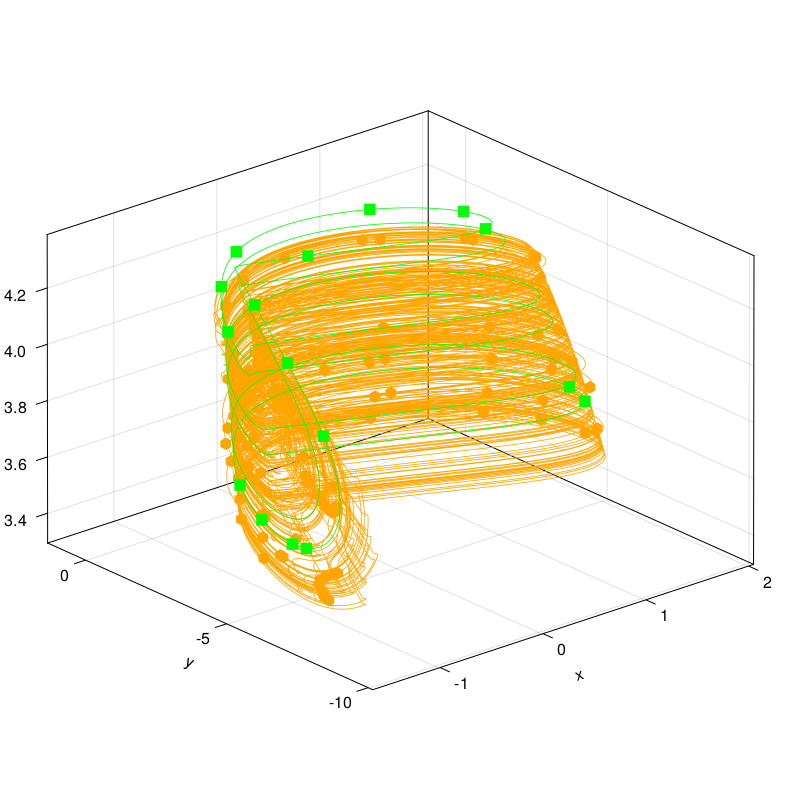

In [57]:
f = Figure(resolution = (800, 800) )
ax = Axis3(f[1,1])

for i in keys(attractors)
    
    tr = attractors[i]
    color = COLORS[i]
    idxs = [1,2,3]
    
    x,y,z = columns(tr)[idxs]
    scatter!(ax, x,y,z;  color = color, marker =  markers_labels[i][1],  markersize = 15)
    
    tr = trajectory(ds, 5000, tr[1]; Ttr = 2000, diffeq = (alg = Vern9(), abstol = 1e-11, reltol = 1e-11,  maxiters = 10000000) )
    x,y,z = columns(tr)[idxs]
    lines!(ax, x,y,z; linewidth = 0.8, color = color)
    
end
f

In [58]:
ids = sort!(unique(basins))

3-element Vector{Int16}:
 -1
  1
  2

In [62]:
generate_cmap(n) = cgrad(COLORS[1:n], n; categorical = true)
cmap = generate_cmap(length(ids))

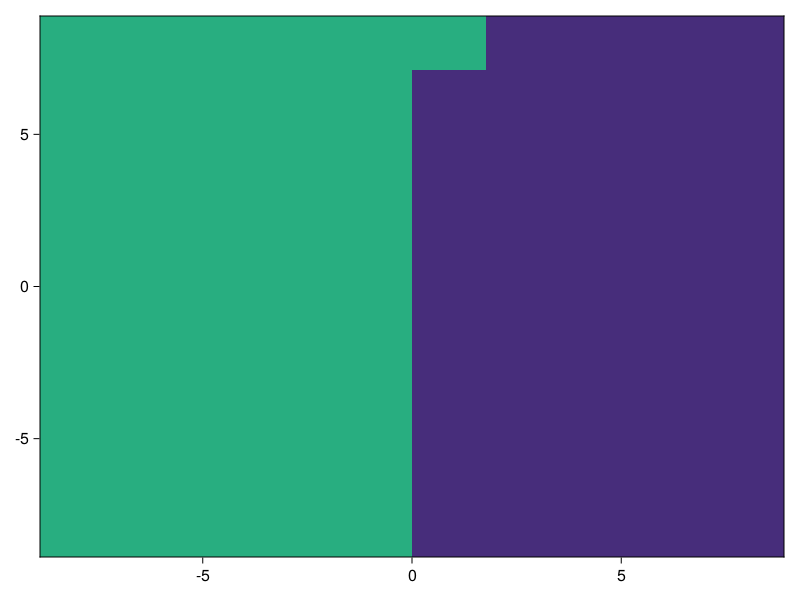

In [118]:
fig, ax = heatmap(xr1, xr2, basins[:, :, 1, 1, 1, 1];
        cmap = cmap,
    colorrange = (ids[1] - 0.5, ids[end]+0.5)
)